In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import scipy

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

import read_data

In [31]:
file_location="../amp-parkinsons-disease-progression-prediction"
readData = read_data.data()

Some old Clustering Code for function tested for train_clinical data.
Might be usefull for future timeseries analysis

## Clustering

In [15]:
def COSSIM(f,g, eps=10**-20):
    # Similarity between two functions measured: Integral(f'g')/sqrt(Integral(f'**2)*Integral(g'**2))
    # https://en.wikipedia.org/wiki/Cosine_similarity
    f_diff = f[...,1:]-f[...,:-1]
    g_diff = g[...,1:]-g[...,:-1]
    dxfdxg = f_diff*g_diff+eps
    dxf2 = np.square(f_diff)+eps
    dxg2 = np.square(g_diff)+eps
    return np.sum(dxfdxg, axis=-1)/(np.sqrt(np.sum(dxf2, axis=-1))*np.sqrt(np.sum(dxg2, axis=-1)))

In [16]:
def metric_COSSIM(f,g):
    c = COSSIM(f,g)
    return np.sqrt(np.abs(1-c))

In [17]:
def sim_affinity(X):
    return pairwise_distances(X, metric=metric_COSSIM)

## Clustering Data

In [77]:
def cluster_data(data, x_vals,subtract_min_in_plot=True, show_linregr=True):

    # interpolating nan values, this can probably be done better ^^
    data = np.array([np.interp(np.arange(len(d)), 
              np.arange(len(d))[np.isnan(d) == False], 
              d[np.isnan(d) == False]) for d in data])

    data.shape

    n_clusters = 40
    distance_threshold = None
    samples = 1500

    cluster = AgglomerativeClustering(n_clusters=n_clusters,
                                      distance_threshold=distance_threshold,
                                      affinity=sim_affinity, linkage='average')

    cluster.fit(data);

    plt.figure(figsize=(20,20))
    plt.suptitle("Clusters ")
    for clus in range(max(cluster.labels_)+1):
        for index in np.argwhere(cluster.labels_==clus):           
            plt.subplot(10,4,clus+1)
            plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            min_val = 0
            if subtract_min_in_plot:
                min_val=np.min(data[index])
            x, y = x_vals, (data[index]-min_val)[0]
            plt.plot(x, y ,color="red", alpha = .5);  
            if show_linregr:
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
                plt.plot(x, [_*slope+intercept for _ in x] ,color="blue", alpha = .3); 

# Tests

D:\PythonProjects\Parkinsons-Progression-Prediction\src\read_data.py:72: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  return pd.pivot_table(self.train_clinical,index = 'patient_id',columns =['visit_month'])
C:\Users\Thiele\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


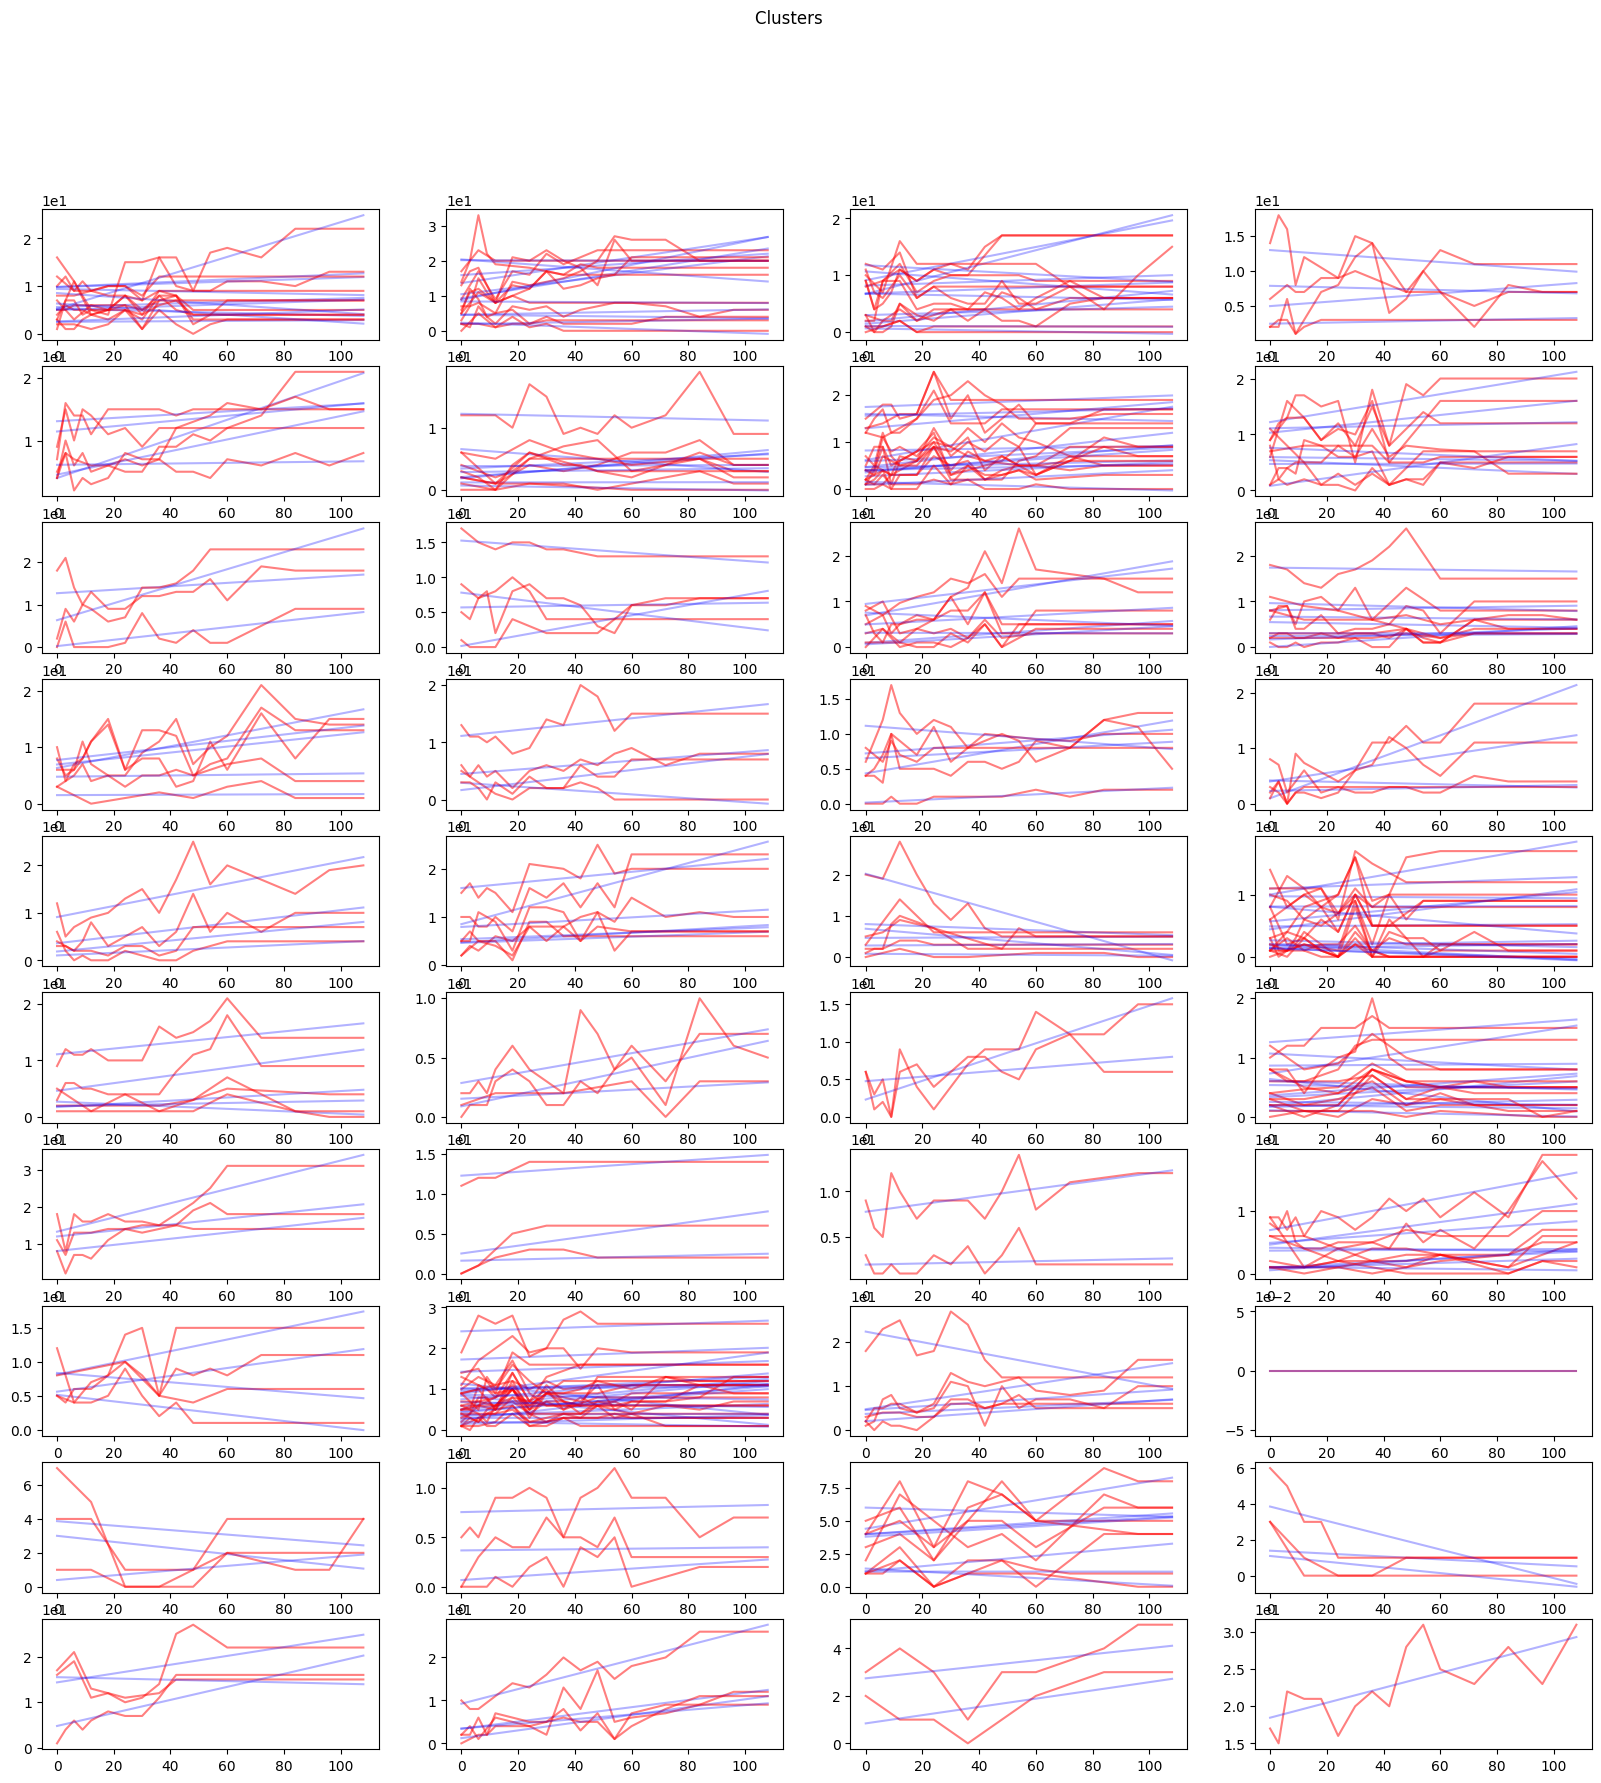

In [78]:
a = readData.y_data_3d()
cluster_data(np.array(a['updrs_1']), a['updrs_1'].columns, False, True)

D:\PythonProjects\Parkinsons-Progression-Prediction\src\read_data.py:61: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df_uniprot = pd.pivot_table(df_uniprot, index='patient_id', columns=['visit_month'])
D:\PythonProjects\Parkinsons-Progression-Prediction\src\read_data.py:63: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df_peptide = pd.pivot_table(df_peptide, index='patient_id', columns=['visit_month'])
C:\Users\Thiele\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


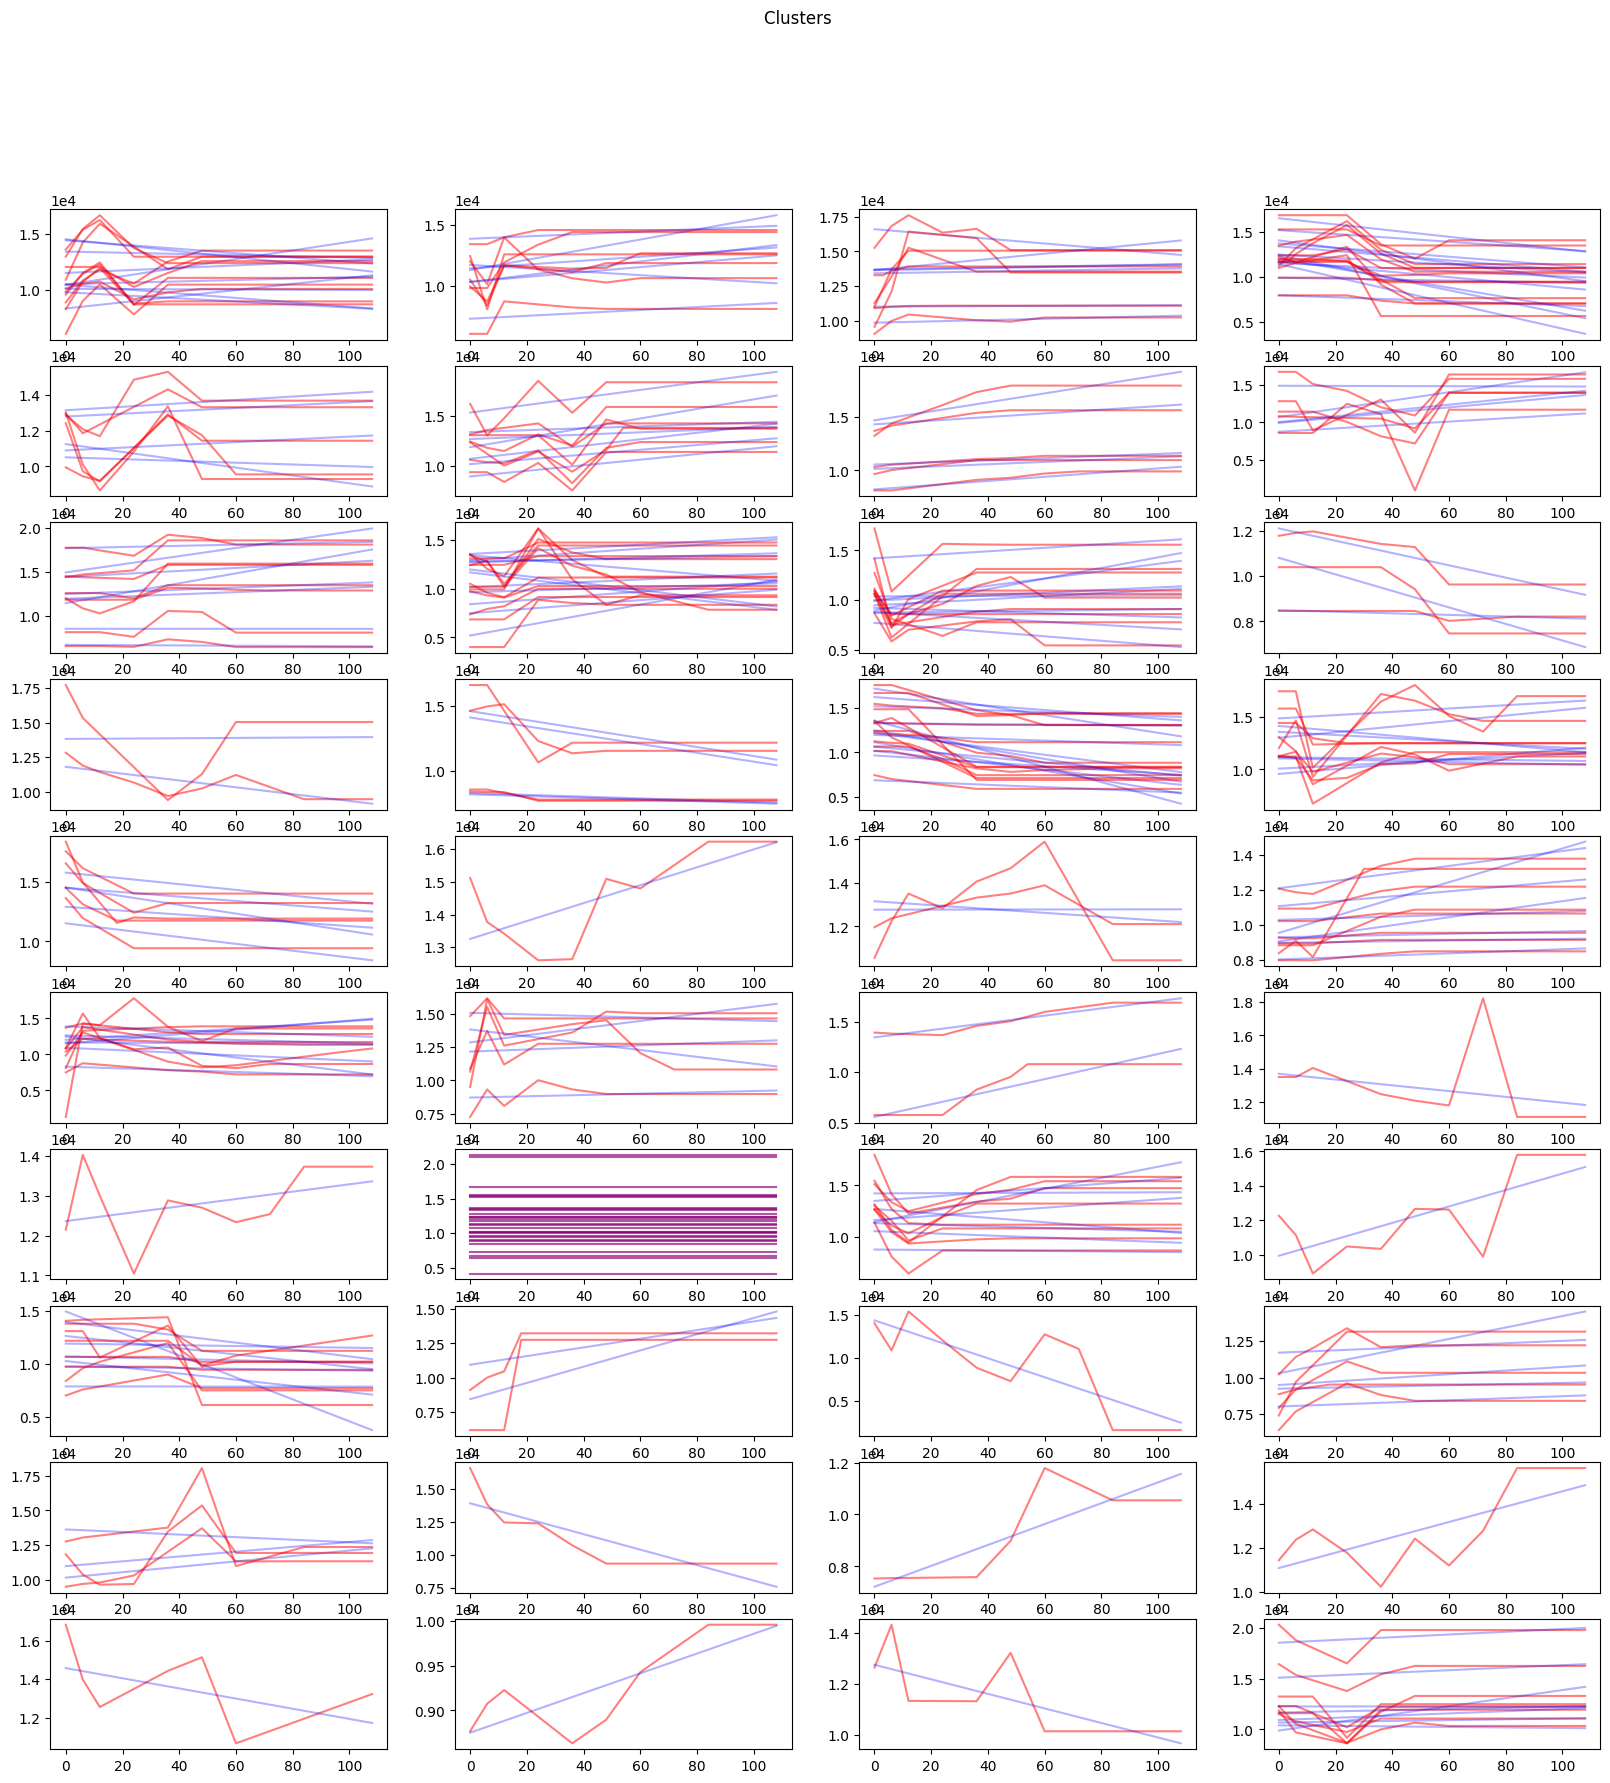

In [79]:
a = readData.x_data_3d()[0]['O00391'].dropna(axis = 0, how = 'all')
cluster_data(np.array(a), a.columns, False, True)